# **SDSS光谱作图并筛选特征谱线**

* 输入为hdu格式，若fits文件需要先打开

In [1]:
import math
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np
from astropy.io import fits

import scipy.interpolate as spi
from sklearn.preprocessing import MinMaxScaler
import cv2

from astroquery.sdss import SDSS

In [2]:
elines = {
    3727.0:'O II',
    3728.3:'O II',
    4364.4:'O III',
    4960.2:'O III',
    5008.2:'O III',
    8498.0:'Ca II',
    8542.0:'Ca II',
    8662.0:'Ca II',
    8929.0:'Ca II',
    9572.0:'Ca II'
};
fe_II_lines = {
    3277.0:'Fe II',
    4175.0:'Fe II',
    4178.0:'Fe II',
    4234.0:'Fe II',
    4297.0:'Fe II',
    4303.0:'Fe II',
    4388.0:'Fe II',
    4417.0:'Fe II',
    4492.0:'Fe II',
    4520.0:'Fe II',
    4549.0:'Fe II',
    4556.0:'Fe II',
    4584.0:'Fe II',
    4630.0:'Fe II',
    4924.0:'Fe II',
    5021.0:'Fe II',
    5175.0:'Fe II/Mg I blend',
    5198.0:'Fe II',
    5234.0:'Fe II',
    5276.0:'Fe II',
    5285.0:'Fe II',
    5316.0:'Fe II',
    5363.0:'Fe II',
    5426.0:'Fe II',
    5534.0:'Fe II',
    5991.0:'Fe II',
    6240.0:'Fe II',
    6249.0:'Fe II',
    6318.0:'Fe II',
    6385.0:'Fe II',
    6457.0:'Fe II',
    6493.0:'Fe II',
    6516.0:'Fe II',
    7713.0:'Fe II',
    9999.0:'Fe II'
};

fe_I_lines = {
    3407.5:'Fe I',
    3441:'Fe I',
    3465:'Fe I',
    3475:'Fe I',
    3490:'Fe I',
    3526:'Fe I',
    3565:'Fe I',
    3608:'Fe I',
    3631:'Fe I',
    3722:'Fe I',
    3749:'Fe I',
    3824:'Fe I',
    3856:'Fe I',
    3899:'Fe I',
    4045:'Fe I',
    4071:'Fe I',
    4133:'Fe I',
    4143:'Fe I',
    4250:'Fe I',
    4260:'Fe I',
    4272:'Fe I',
    4308:'Fe I',
    4325:'Fe I',
    4383:'Fe I',
    4404:'Fe I',
    4427:'Fe I',
    4871:'Fe I',
    4920:'Fe I',
    5269.5:'Fe I',
    5328:'Fe I',
    5397:'Fe I',
    5429:'Fe I',
    5497:'Fe I'
};

alines = {
    
    
    3832:'Mg I',
    3843:'Mg I',
    3933.7:'Ca II K',
    3968.5:'Ca II H',
    
    3970:r'H$\epsilon$',

    3888:'He',
    3891:r'H$\zeta$',
    4026:'He',
    4101.7:r'H$\delta$',
    4143:'He',
    4226.73:'Ca I',
    4340.4:r'H$\gamma$',
    4388:'He',
    4455:'Ca I',
    4471:'He',
    4481:'Mg I doublet',
    4861.3:r'H$\beta$',
    4922:'He',
    5015:'He',
    
    5167:'Mg I b Triplet',
    5172:'Mg I b Triplet',
    5183:'Mg I b Triplet',
    5207:'Cr I',
    5528:'Mg I',
    5582:'Ca I',
    5711:'Mg I',
    5876:'He',
    5893:'Na D Doublet',
    
    6162:'Ca I',
    6439:'Ca I',
    6562.7:r'H$\alpha$',
     
    7691:'Mg I',
    
    8498:'Ca II  Triplet',
    8542:'Ca II IR Triplet',
    8662:'Ca II IR Triplet',
}    
Check_lines = {   
    6562.7:r'H$\alpha$',
    3933.7:'Ca II K',
    3968.5:'Ca II H',
    8498:'Ca II IR Triplet',
    8542:'Ca II IR Triplet',
    8662:'Ca II IR Triplet',
};

In [3]:
emission_lines = [list(elines.keys()) ,list(elines.values())]
absorption_lines = [list(alines.keys()) ,list(alines.values())]
Fe_I_lines = [list(fe_I_lines.keys()) ,list(fe_I_lines.values())]
Fe_II_lines = [list(fe_II_lines.keys()) ,list(fe_II_lines.values())]
check_lines = [list(Check_lines.keys()) ,list(Check_lines.values())]

In [4]:
def lines_check(lines, x, y, delta_fix, delta, center_broading, peripheral_broading):
    for i in range(0,len(lines[0])):
        if min(x) <= lines[0][i] <= max(x):
            ave_c = sum(y[(lines[0][i] - center_broading < x)
                              &(x <lines[0][i] + center_broading)]) / len(y[(lines[0][i] - center_broading < x)
                              &(x <lines[0][i] + center_broading)])
            
            ave_p = (sum(y[(lines[0][i] + center_broading < x)
                             &(x < lines[0][i] + center_broading + peripheral_broading)])
                     + sum(y[(lines[0][i] - center_broading - peripheral_broading < x)
                                &(x < lines[0][i] - center_broading)])) / (len(y[(lines[0][i] + center_broading < x)
                     &(x < lines[0][i] + center_broading + peripheral_broading)])
               + len(y[(lines[0][i] - center_broading - peripheral_broading < x)
                                &(x < lines[0][i] - center_broading)]))
            
            if (ave_p - ave_c) / delta_fix >= delta:
                print(lines[1][i])

In [5]:
def lines_set(lines , z , color , xmin , xmax):
    if z == -9999:
        delta_z = 0
    else:
        delta_z = z
    for i in range(0,len(lines[0])):
        plt.axvline(x = lines[0][i] / (delta_z + 1), color = color, linestyle='--', linewidth = 0.7)
        if xmin < lines[0][i] / (delta_z + 1) < xmax:
            plt.text(x = lines[0][i] / (delta_z + 1), 
                     y = (1 - i / len(lines[0])), 
                     s = lines[1][i],
                     color = color,
                     rotation = - 15,
                     fontsize = 12)

In [6]:
def FitsPlot(file , xmin = 3500 , xmax = 9500 , zchange = -9999 , pattern = 0, a = 5, IVAR = True, lines = False, Fe_lines = False, recognize = True, delta = 3.5e-06,
             center_broading = 5,
             peripheral_broading = 15):
    plt.figure(figsize=(16, 16),dpi=80)#调整绘制的图片的比例
    axes = plt.subplot(211)
    axes.tick_params(axis="both", which="major", direction="out", length = 10)
    axes.tick_params(axis="both", which="minor", direction="out", length = 5)
    axes.xaxis.set_minor_locator(MultipleLocator(100))
    axes.xaxis.set_major_locator(MultipleLocator(500))
    axes.set_xlim(xmin , xmax)

    file_fits = file[0]
    if lines == True:
        if zchange == -9999:
            z = file_fits[2].data['Z']
            lines_set(emission_lines , z , 'green' , xmin , xmax)
            lines_set(absorption_lines , z , 'red' , xmin , xmax)
            
        else:
            lines_set(emission_lines , zchange , 'green' , xmin , xmax)
            lines_set(absorption_lines , zchange , 'red' , xmin , xmax)
    
    if Fe_lines == True:
        if zchange == -9999:
            z = file_fits[2].data['Z']
            lines_set(Fe_I_lines , z , 'purple' , xmin , xmax)
            lines_set(Fe_II_lines , z , 'orange' , xmin , xmax)
        
        else:
            lines_set(emission_lines , zchange , 'green' , xmin , xmax)
            lines_set(absorption_lines , zchange , 'red' , xmin , xmax)
    
    X_Original = 10**file_fits[1].data['loglam'][(xmin < 10**file_fits[1].data['loglam'])
                                           &(10**file_fits[1].data['loglam'] < xmax)]
    Y_Original = file_fits[1].data['flux'][(xmin < 10**file_fits[1].data['loglam'])
                                           &(10**file_fits[1].data['loglam'] < xmax)]
    Y = []
    X = []
    print(len(X_Original))    
    #原始数据绘图
    if pattern == 0: 
        Y = Y_Original
        X = X_Original
 
    #数据平均化绘图
    elif pattern == 1:
        for i in range(0 , len(Y_Original) - a + 1):
            Y.append(np.average(Y_Original[i : i + a]))
            X.append(np.average(X_Original[i : i + a]))
    
    #三阶样条插值后高斯滤波绘图
    elif pattern == 2:
        ipo = spi.splrep(X_Original , Y_Original , k = 3)
        X = X_Original
        Y = spi.splev(X, ipo)
        Y = cv2.GaussianBlur(src = Y, ksize = (29, 29), sigmaX = 5)
        
    else:
        print('Pattern is in [0,2]')
    
    #Y的归一化处理
    Y = (Y - min(Y))/(max(Y) - min(Y))

    plt.plot(X, Y, color='blue', linewidth = 1)#按照之前的XY以蓝色、线宽0.5来绘制
    #plt.title(file_fits[0].header['FILENAME'])
    plt.xlabel(r'Wavelength ($\rm{\AA}$)')#绘制x轴
    plt.ylabel(r'Flux ($\rm 10^{-17}\cdot erg\cdot s^{-1}\cdot cm^{-2}\cdot \AA^{-1}$)')#绘制y轴
    plt.show()
        #part C
    if recognize == True:
        delta_fix = (max(file_fits[1].data['flux']) - min(file_fits[1].data['flux']))/(max(Y) - min(Y))
        lines_check(check_lines, X, Y, delta_fix, delta = delta, center_broading = center_broading, peripheral_broading = peripheral_broading)
    file_fits.close()

In [7]:
eg=SDSS.get_spectra(plate = 6153, mjd = 56164, fiberID = 216, data_release = 16)

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\astroquery\sdss\core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


1015


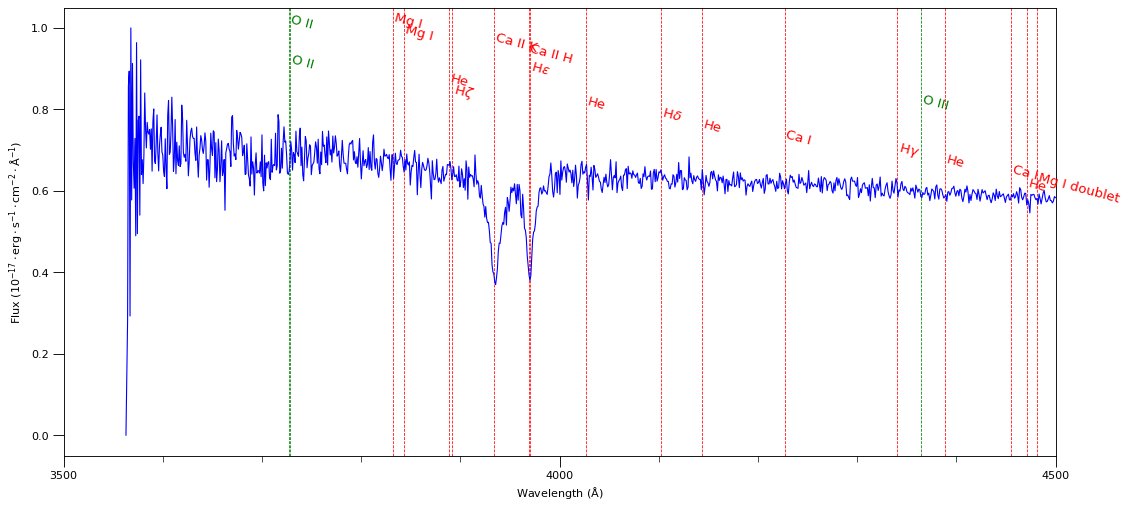

Ca II K
Ca II H


In [8]:
FitsPlot(eg,lines = True,xmin = 3500, xmax =4500)

In [14]:
eg[0][2].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                 3931 /Number of bytes per row                         
NAXIS2  =                    1 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                  236 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **